# Mask R-CNN for Keypoint Detection

Notebook for inspecting the Mask R-CNN data loader and model classes

In [1]:
USE_GPU = False

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load COCO Data for Keypoint Detection

In [2]:
from coco import coco_keypoints
importlib.reload(coco_keypoints)

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare datasets
#keypoints_to_include = ['nose', 'left_shoulder', 'right_shoulder',
#                        'left_elbow', 'right_elbow', 'left_wrist',
#                        'right_wrist', 'left_hip', 'right_hip',
#                        'left_knee', 'right_knee', 'left_ankle',
#                        'right_ankle']
keypoints_to_include = None

dataset_train = coco_keypoints.CocoDataset()
dataset_train.load_coco(COCO_DATA_DIR, subset="train", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_train.prepare()

dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True, keypoints_to_include=keypoints_to_include)
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/train2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_train2017.json
loading annotations into memory...
Done (t=9.89s)
creating index...
index created!
Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


### List the Keypoint Classes

In [3]:
print("Classes:")
print(dataset_val.class_names)
print()
print("Keypoint classes:")
print(dataset_val.kp_class_names)

Classes:
['BG', 'person']

Keypoint classes:
['MISSING', 'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


### Show an Example Image
Shows how to use ```visualize.display_keypoints``` to show keypoints on an image

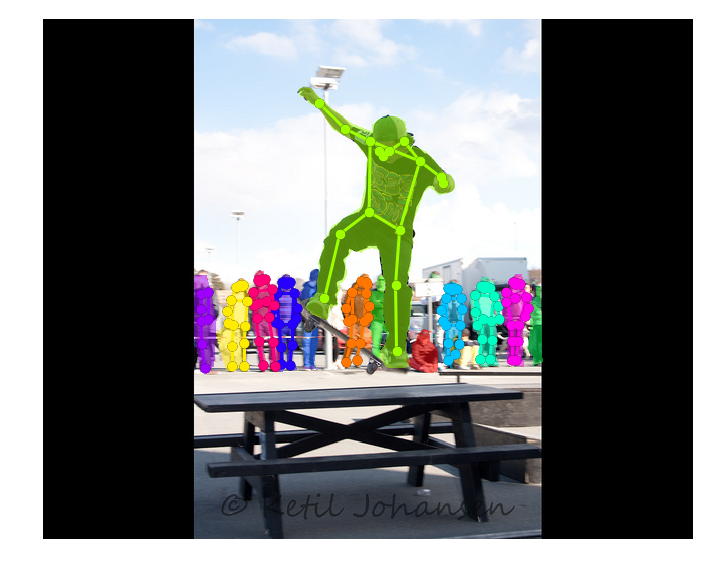

In [8]:
importlib.reload(visualize)

# Get an image from the validation set
image_id = dataset_train.image_ids[3]
image = dataset_train.load_image(image_id)

# Load masks and coresponding kp ids
masks, class_ids, kp_masks, kp_ids, bbox = dataset_train.load_mask(image_id, return_boxes=True)

# Show keypoints
visualize.display_keypoints(image, bbox, kp_masks, kp_ids,
                            masks, show_masks=True,
                            skeleton=dataset_val.skeleton,
                            figsize=(12, 12))

## Inspect Model

In [5]:
class TestConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_train.num_classes
    NUM_KEYPOINTS = dataset_train.num_kp_classes
    RPN_NMS_THRESHOLD = 0.5
    #MAX_GT_INSTANCES = 2
config = TestConfig()
#config.display()

### Model Dataloader

Show how the networks ```modellib.load_image_gt``` sees the mask, bounding box and kp ids

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
gt_class_ids             shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  144.00000  max:  880.00000  int32
gt_masks                 shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool
gt_kp_masks              shape: (1, 17)               min: 214526.00000  max: 822766.00000  int32
gt_kp_ids                shape: (1, 17)               min:    1.00000  max:   17.00000  int32


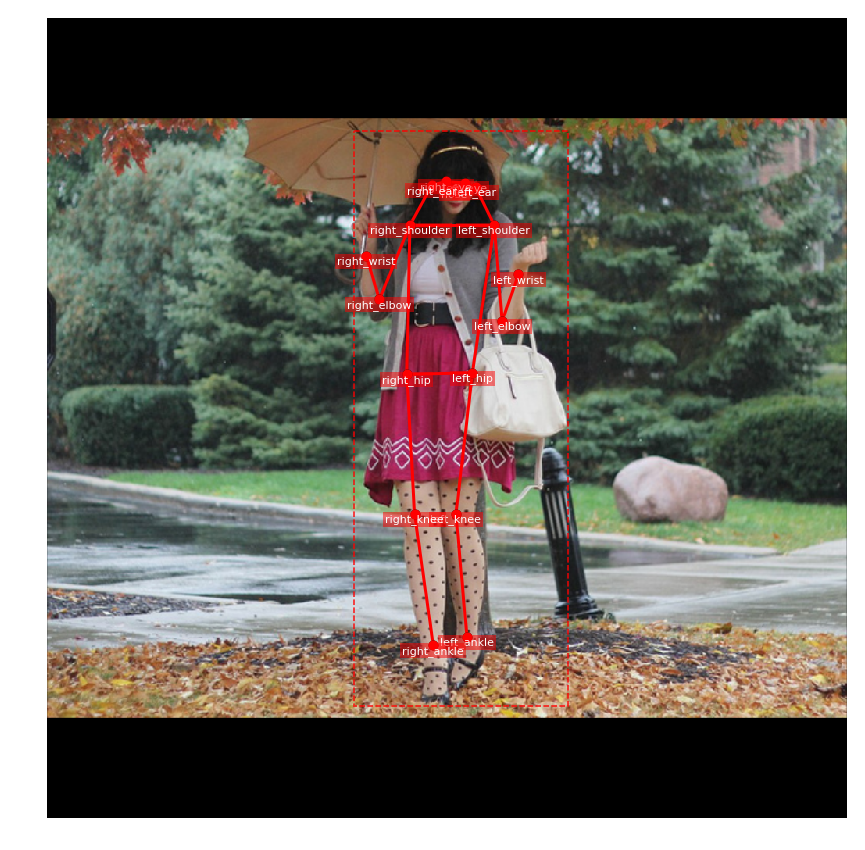

In [6]:
importlib.reload(modellib)
importlib.reload(visualize)

# Load an image from the validation set
image_id = dataset_val.image_ids[10]

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_bbox, gt_masks, gt_kp_ids, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, config, image_id)
    
# Display some tensor sizes
log("image", image)
log("gt_class_ids", gt_class_ids)
log("gt_bbox", gt_bbox)
log("gt_masks", gt_masks)
log("gt_kp_masks", gt_kp_masks)
log("gt_kp_ids", gt_kp_ids)

# Show skeletons
visualize.display_keypoints(image, gt_bbox, utils.sparse_to_dense_masks(gt_kp_masks, image.shape),
                            skeleton=dataset_train.skeleton,
                            captions=dataset_train.kp_class_names,
                            figsize=(15, 15))

## Inference Output

In [7]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  None


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
# Run the inference pipeline on the previous image
results = model.detect([image])
r = results[0]
bbox, masks = r["rois"], r["masks"]

# Show output tensors
log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", masks)

# Show skeletons
visualize.display_keypoints(image, bbox, masks,
                            skeleton=dataset_train.skeleton,
                            figsize=(8, 8))

### Show Keypoint Heatmap

In [ ]:
r['scores']

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

bbox, kp_masks, kp_ids = r["rois"], r["masks"], np.repeat(np.expand_dims(np.arange(17), axis=0), 12, axis=0)

log("image", image)
log("class_ids", r['class_ids'])
log("kp_ids", kp_ids)
log("bbox", bbox)
log("masks", kp_masks)

mask_index = 0

def plot_grid(images, titles=None):
    n = np.sqrt(len(images))
    _, axes = plt.subplots(int(np.ceil(n)), int(np.floor(n)), figsize=(15, 15))
    if n <= 1: axes = np.array(axes)
    for i, ax in enumerate(axes.flatten()):
        ax.axis("off")
        if i >= config.NUM_KEYPOINTS: continue    
        if titles is not None:
            ax.set_title(titles[i])
        ax.imshow(images[i])
    plt.show()

importlib.reload(visualize)
    
plot_grid(kp_masks[mask_index], titles=dataset_val.kp_class_names[1:])
visualize.display_keypoints(image, bbox[mask_index:mask_index+1], kp_masks[mask_index:mask_index+1],
                            #skeleton=dataset_train.skeleton
                            captions=dataset_train.kp_class_names,
                            figsize=(15, 15))

In [ ]:
# Load an image from the validation set
image_id = np.random.choice(dataset_val.image_ids)

# Get ground truth masks and bboxes
image, image_meta, gt_class_ids, gt_kp_ids, gt_bbox, gt_kp_masks = \
    modellib.load_image_gt(dataset_val, config, image_id)

_, axes = plt.subplots(2, 1)

# Show skeletons
visualize.display_keypoints(image, gt_bbox,
                            utils.sparse_to_dense_masks(gt_kp_masks, image.shape),
                            gt_kp_ids,
                            skeleton=dataset_train.skeleton,
                            captions=dataset_train.kp_class_names,
                            ax=axes[0])

# Run the inference pipeline on the previous image
results = model.detect([image])
r = results[0]
bbox, masks = r["rois"], r["masks"]

# Show skeletons
visualize.display_keypoints(image, bbox, masks,
                            skeleton=dataset_train.skeleton,
                            figsize=(8, 8),
                            ax=axes[1])

plt.show()

### Show Grid of Random Images

In [ ]:
# Select 10 random images
images = []
for image_id in random.choice(dataset_val.image_ids, 10, replace=False):
    # Load an image from the validation set
    image_id = dataset_val.image_ids[10]
    image = modellib.load_image_gt(dataset_val, config, image_id)[0]
    images.append(image)

# Detect keypoints
results = model.detect(images)

# Plot results
for r in results:
    visualize.display_keypoints(image, r["rois"], r["masks"],
                                #skeleton=dataset_train.skeleton,
                                figsize=(8, 8))